In [66]:
import numpy as np
import tensorflow as tf
import glob
from pydub import AudioSegment
from audioset import vggish_keras_embeddings
from time import time
import utils
import youtube_dl
import pandas as pd
import h5py
import os
import datetime

%matplotlib inline

In [67]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/oppapie/projects/LaughDetection/utils.py'>

In [68]:
#url = 'https://www.youtube.com/watch?v=fpf1IYU0poY' # Trump state of the union 2019
#url = 'https://www.youtube.com/watch?v=Ymwe4DB_HsU'
url = 'https://www.youtube.com/watch?v=vP4iY1TtS3s' # I have a dream speech
#url = 'https://www.youtube.com/watch?v=-taEc2havwA' # jim carrey speech
#url = 'https://www.youtube.com/watch?v=KRGgQP47Vgw'
def download_audio(url, download=True):

    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': '%(title)s.%(ext)s',
        'writesubtitles': True,
        'writeautomaticsub': True,
        'quiet': True,
        #'progress_hooks': [my_hook],
    }

    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(url, download=download)  # Download into the current working directory
        filename = ydl.prepare_filename(result)
    return filename
filename = download_audio(url)


In [69]:
print(filename)

I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered).m4a


In [70]:
clipsize = 1000
savename=filename+'_clipsize'+str(clipsize)
start = time()
def embed_audio(filename, clipsize=clipsize, savename=filename+'_clipsize'+str(clipsize)):
    if savename[-3:] != '.h5':
        savename = savename + '.h5'
    exists = os.path.isfile(savename)
    if exists:
        print('Embedding file detected.')
        print('Loading embedding file:', savename)
        f = h5py.File(savename, 'r')
        return f.items()
    else:
        print('Embedding file not detected.')
        print('Running embedder on audio.')
        list_of_embeddings = []
        audio_embedder = vggish_keras_embeddings.VGGishEmbedder(None)
        for idx, val in enumerate(utils.sound_slice_generator(filename, clipsize=clipsize, sample_rate=44100)):
            waveform, sample_rate = val[0], val[1]
            if val[0].shape[0] < sample_rate:
                waveform = np.pad(val[0], (0, sample_rate - val[0].shape[0]), mode='constant')
            processed_embedding =  audio_embedder.convert_waveform_to_embedding(waveform, sample_rate)

            embedding_final = np.expand_dims(processed_embedding, axis=0)
            list_of_embeddings.append((idx, embedding_final))
            if idx != 0 and idx % 100 == 0:
                print(idx, "samples embedded")
        utils.save_embeddings_hdf(savename, list_of_embeddings)
        print('Saved embeddings to:', savename)
        return list_of_embeddings

predictions = []

model = tf.keras.models.load_model('Models/v2_cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

for idx, v in embed_audio(filename, clipsize=clipsize):
    predictions.append((idx, model.predict(v)))
    
end = time()
print(end - start)

W0401 03:26:05.714692 140597598123840 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdadf95ac50>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0401 03:26:05.848180 140597598123840 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdab7349f98>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0401 03:26:05.984730 140597598123840 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fdab20e96d8>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


Embedding file not detected.
Running embedder on audio.
No of sound slices 812.1875736961451
100 samples embedded
200 samples embedded
300 samples embedded
400 samples embedded
500 samples embedded
600 samples embedded
700 samples embedded
800 samples embedded
Saved embeddings to: I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered).m4a_clipsize1000.h5
46.114290952682495


In [90]:
predictions = []

model = tf.keras.models.load_model('Models/cheer_applause_LSTM_ThreeLayer_100Epochs.h5')

for idx, v in list_of_embeddings:
    predictions.append((idx, model.predict(v)))

W0329 13:24:51.809915 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef7f6163a20>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 13:24:51.956087 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef7f17c2be0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0329 13:24:52.102088 139623814866752 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7ef7f156a518>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.


In [30]:
utils.save_embeddings_hdf(filename, list_of_embeddings)

## Plotting time of video vs prediction

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

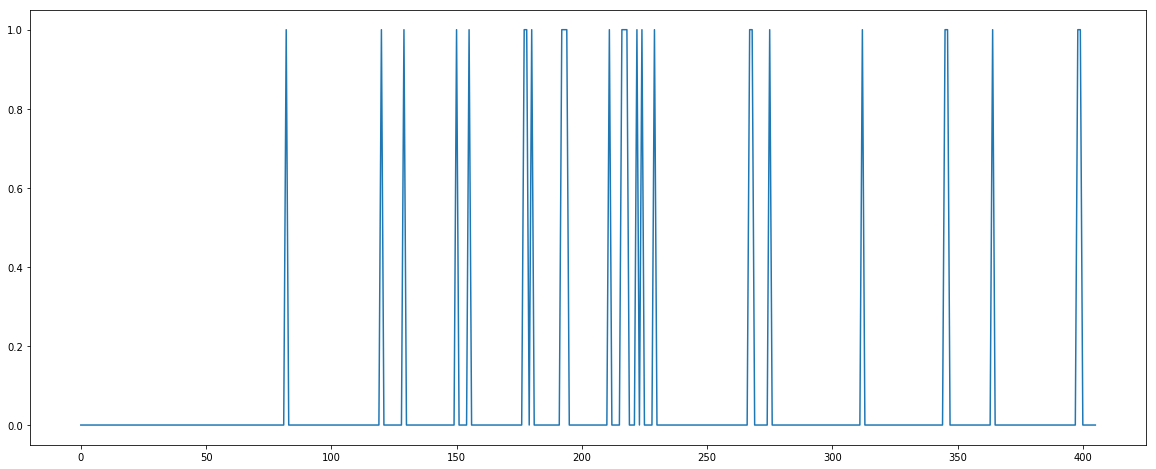

In [91]:
x = [int(i[0]) for i in predictions]
#y = [i[1][0][0] if i[1][0][0] > 0.6 else 0.59 for i in predictions  ]
y = [1 if i[1][0][0] > 0.7 else 0 for i in predictions  ]
clrs = ['grey' if (x < 0.7) else 'red' for x in y ]
plt.figure(figsize=(20,8))
#plt.ylim(0.59, .)

sns.lineplot(x, y)




## Saving predictions to csv

In [71]:
x = [datetime.timedelta(seconds=float(i[0])/(2000/clipsize)) for i in predictions]
y = [i[1][0][0] for i in predictions]

df = pd.DataFrame({'timestamp': x, 'prediction': y})
df.to_csv(savename+'_predictions.csv', index=False)
print(savename+'_predictions.csv')

I Have a Dream speech by Martin Luther King .Jr HD (subtitled) (Remastered).m4a_clipsize1000_predictions.csv


In [47]:
df['prediction'].describe(percentiles=np.linspace(.1,.9, num=9))

count    9894.000000
mean        0.542577
std         0.015801
min         0.479638
10%         0.523550
20%         0.527021
30.0%       0.530688
40%         0.536030
50%         0.542355
60%         0.547658
70%         0.552305
80%         0.556844
90%         0.563078
max         0.612577
Name: prediction, dtype: float64

In [9]:
len(predictions)

812

In [19]:
clipsize

2000

In [33]:
max(x)

datetime.timedelta(seconds=470)

In [49]:
from pydub import AudioSegment
from scipy.io import wavfile
sound = AudioSegment.from_file("Toy Story Toons 'Small Fry' Sneak Peek.webm")
sound.export('Toy Story Toons \'Small Fry\' Sneak Peek.wav', format='wav')
wave = wavfile.read('Toy Story Toons \'Small Fry\' Sneak Peek.wav')
channel_count = sound.channels

In [56]:
len(wave[1])

1542303

In [18]:
sound.sample_width

4

In [57]:
sound = sound.set_channels(1)
sound = sound.set_sample_width(2)

In [65]:
np_samples = np.array(sound.get_array_of_samples()).reshape((-1,1))
np_samples[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int16)

In [28]:
list_sounds = sound[::1000]

i = 0
for i, v in enumerate(list_sounds):
    samples = v.get_array_of_samples()
    np_samples = np.array(samples)
    s_reshaped = np_samples.reshape((-1,2))
    print(s_reshaped.shape[0], v.frame_rate)

22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
22050 44100
2205